In [48]:
# Install Kaggle API for download competition data
!pip3 install -q kaggle

In [49]:
!pip install pydicom

In [50]:
# Imports

import numpy as np
import pandas as pd
import os
import random 
from shutil import copyfile
import pydicom as dicom
import cv2
import matplotlib.pyplot as plt
from matplotlib.image import imread

from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras import backend as K 
K.set_image_data_format('channels_last')

## Data

### Kaggle rsna

In [51]:
# download your Kaggle json on your account page on Kaggle

kjson = pd.read_json('kaggle.json',typ='series')

In [52]:
# enter your Kaggle credentionals here

os.environ['KAGGLE_USERNAME']= "matheuscoradini"
os.environ['KAGGLE_KEY']= kjson.key

In [53]:
!kaggle datasets download --force tawsifurrahman/covid19-radiography-database

 99% 1.14G/1.15G [00:12<00:00, 79.7MB/s]
100% 1.15G/1.15G [00:12<00:00, 100MB/s] 


In [54]:
!kaggle datasets download --force raddar/tuberculosis-chest-xrays-shenzhen

100% 3.50G/3.51G [01:22<00:00, 20.8MB/s]
100% 3.51G/3.51G [01:22<00:00, 45.7MB/s]


In [55]:
!unzip covid19-radiography-database.zip

Archive:  covid19-radiography-database.zip
replace COVID-19 Radiography Database/COVID-19.metadata.xlsx? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [56]:
!unzip tuberculosis-chest-xrays-shenzhen.zip

Archive:  tuberculosis-chest-xrays-shenzhen.zip
replace images/images/CHNCXR_0001_0.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

# Metadata

In [57]:
meta_tub = pd.read_csv('shenzhen_metadata.csv')

In [58]:
meta_tub.head()

,study_id,sex,age,findings
0,CHNCXR_0001_0.png,Male,45,normal
1,CHNCXR_0002_0.png,Male,63,normal
2,CHNCXR_0003_0.png,Female,48,normal
3,CHNCXR_0004_0.png,Male,58,normal
4,CHNCXR_0005_0.png,Male,28,normal


In [59]:
meta_tub.findings.value_counts().head(20)

normal                                         326
bilateral PTB                                   61
Right PTB                                       45
PTB in the right upper field                    27
STB                                             19
PTB in the left upper field                     19
left PTB                                        19
Bilateral secondary PTB                         16
secondary PTB  in the right upper field         12
right secondary PTB                             10
secondary PTB  in the left upper field           8
PTB in the bilateral upper field                 8
secondary PTB  in the bilateral upper field      6
right upper PTB                                  6
PTB in the right lower field                     4
left secondary PTB                               3
PTB in the bilateral upper fields                3
PTB in the left lower field                      3
PTB  in the right upper field                    3
right lower field PTB          

In [60]:
meta_tub.loc[meta_tub['findings'] == 'normal', 'findings'] = 1
meta_tub.loc[meta_tub['findings'] != 1, 'findings'] = 3

In [61]:
meta_tub.findings.value_counts()

3    336
1    326
Name: findings, dtype: int64

In [62]:
y_tub = meta_tub.findings

## Image dir

In [63]:
os.listdir('COVID-19 Radiography Database/')

['Viral Pneumonia',
 'NORMAL',
 'README.md.txt',
 'Viral Pneumonia.matadata.xlsx',
 'NORMAL.metadata.xlsx',
 'COVID-19.metadata.xlsx',
 'COVID-19']

In [64]:
imagens_normal = 'COVID-19 Radiography Database/NORMAL'
imagens_covid = 'COVID-19 Radiography Database/COVID-19'
imagens_pneu = 'COVID-19 Radiography Database/Viral Pneumonia'
imagens_sh = 'images/images'

In [65]:
print(len(os.listdir(imagens_normal)))

1341


In [66]:
print(len(os.listdir(imagens_covid)))

219


In [67]:
print(len(os.listdir(imagens_pneu)))

1345


In [68]:
covid_image_list = os.listdir(imagens_normal)
normal_image_list = os.listdir(imagens_covid)
pneu_image_list = os.listdir(imagens_pneu)
sh_image_list = os.listdir(imagens_sh)

# Preparing features

In [69]:
paths = []
y = []

for dirname, _, filenames in os.walk('COVID-19 Radiography Database/Viral Pneumonia'):
    for filename in filenames:
        if (filename[-3:] == 'png'):
            paths.append(os.path.join(dirname, filename))
            y.append(0)
            
for dirname, _, filenames in os.walk('COVID-19 Radiography Database/NORMAL'):
    for filename in filenames:
        if (filename[-3:] == 'png'):
            paths.append(os.path.join(dirname, filename))
            y.append(1)   

for dirname, _, filenames in os.walk('COVID-19 Radiography Database/COVID-19'):
    for filename in filenames:
        if (filename[-3:] == 'png'):
            paths.append(os.path.join(dirname, filename))
            y.append(2)

for dirname, _, filenames in os.walk(imagens_sh):
    for filename in filenames:
        if (filename[-3:] == 'png'):
            paths.append(os.path.join(dirname, filename))
y_tub = list(y_tub)
y.extend(y_tub)

In [70]:
len(paths)

3567

In [71]:
len(y)

3567

In [72]:
X = []
for i in paths:
    image = cv2.imread(i)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (128, 128))

    X.append(image)

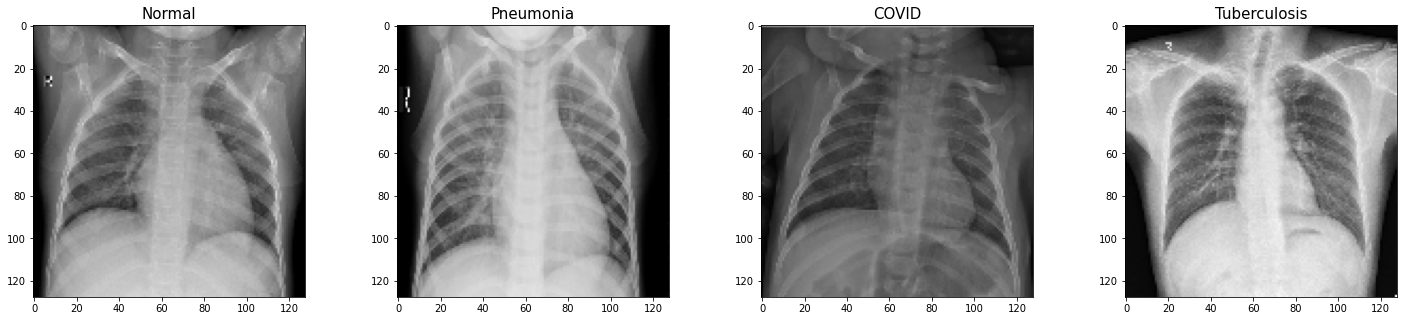

In [73]:
fig, (ax1, ax2,ax3,ax4) = plt.subplots(ncols = 4,nrows = 1, figsize = (25,5))
ax1.imshow(X[1500],cmap='gray')
ax2.imshow(X[0],cmap='gray')
ax3.imshow(X[2900],cmap='gray')
ax4.imshow(X[-1],cmap='gray')

ax1.set_title('Normal',fontsize=15)
ax2.set_title('Pneumonia',fontsize=15)
ax3.set_title('COVID',fontsize=15)
ax4.set_title('Tuberculosis',fontsize=15)

plt.show()

# Normalizing and reshaping

In [74]:
X = np.array(X)/255
y = np.array(y)

In [75]:
X.shape

(3567, 128, 128, 3)

# Train Test Split

In [76]:
Xtrain, Xval, ytrain, yval  = train_test_split(X, y, test_size = 0.33, random_state = 42)

In [77]:
Xtrain.shape

(2389, 128, 128, 3)

In [78]:
ycat_val = to_categorical(yval,4)
ycat_train = to_categorical(ytrain,4)

In [79]:
ycat_val.shape

(1178, 4)

# Model

In [80]:
modelo_base = InceptionV3(weights='imagenet', include_top= False, input_shape=(128,128,3))

In [81]:
modelo_base.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 63, 63, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 63, 63, 32)   96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 63, 63, 32)   0           batch_normalization_94[0][0]     
_______________________________________________________________________________________

In [82]:
num_classes=4

In [83]:
# Cria a sequência de camadas
add_model = Sequential()

# Adiciona primeiro o modelo base
add_model.add(modelo_base)

# Precisamos de uma camada global de Pooling
add_model.add(GlobalAveragePooling2D())

# Dropout para regularização e evitar overfitting
add_model.add(Dropout(0.5))

# Camada densa na camada final com ativação softmax para previsão das probabilidades das classes
add_model.add(Dense(num_classes, activation = 'softmax'))

In [84]:
add_model.compile(optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'])

In [85]:
# Regra para a redução da taxa de aprendizado
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', patience = 3, verbose = 1, factor = 0.5, min_lr = 0.00001)

In [86]:
image_gen = ImageDataGenerator(rotation_range=20, # rotate the image 20 degrees
                               zoom_range=0.05, # Zoom in by 5% max
                               fill_mode='nearest' # Fill in missing pixels with the nearest filled value
)
image_gen.fit(Xtrain)

In [87]:
cw = {0: 1, 1: 1, 2:3, 3:1.5}

results = add_model.fit_generator(image_gen.flow(Xtrain, ycat_train), epochs=100,validation_data=(Xval,ycat_val), callbacks = [reduce_lr], class_weight=cw)

Epoch 1/100
75/75 [==============================] - 15s 200ms/step - loss: 1.0897 - accuracy: 0.7346 - val_loss: 4159.4468 - val_accuracy: 0.0976 - lr: 0.0010
Epoch 2/100
75/75 [==============================] - 11s 149ms/step - loss: 0.8332 - accuracy: 0.7765 - val_loss: 27.0169 - val_accuracy: 0.4049 - lr: 0.0010
Epoch 3/100
75/75 [==============================] - 11s 148ms/step - loss: 0.7877 - accuracy: 0.7815 - val_loss: 9.6723 - val_accuracy: 0.4796 - lr: 0.0010
Epoch 4/100
75/75 [==============================] - 11s 149ms/step - loss: 0.6292 - accuracy: 0.7928 - val_loss: 2.3900 - val_accuracy: 0.5730 - lr: 0.0010
Epoch 5/100
75/75 [==============================] - 11s 151ms/step - loss: 0.4612 - accuracy: 0.8363 - val_loss: 0.6501 - val_accuracy: 0.7351 - lr: 0.0010
Epoch 6/100
75/75 [==============================] - 12s 154ms/step - loss: 0.5603 - accuracy: 0.8192 - val_loss: 2.0216 - val_accuracy: 0.5093 - lr: 0.0010
Epoch 7/100
75/75 [==============================] - 1

In [88]:
add_model.metrics_names

['loss', 'accuracy']

In [89]:
losses = pd.DataFrame(add_model.history.history)

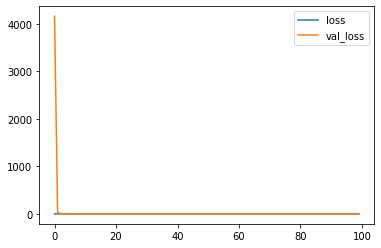

In [90]:
losses[['loss','val_loss']].plot()
plt.show()

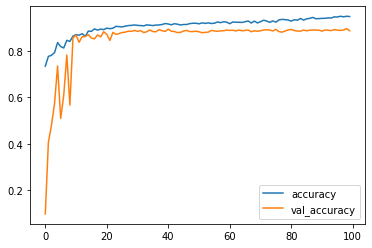

In [91]:
losses[['accuracy','val_accuracy']].plot()
plt.show()

In [92]:
pred = add_model.predict_classes(Xval)

In [93]:
# 0: Pneumonia
# 1: Normal
# 2: COVID-19
# 3: Tuberculosis

from sklearn.metrics import classification_report
print(classification_report(yval, pred))

              precision    recall  f1-score   support

           0       0.99      0.95      0.97       463
           1       0.86      0.90      0.88       529
           2       0.95      0.97      0.96        73
           3       0.55      0.52      0.54       113

    accuracy                           0.89      1178
   macro avg       0.84      0.84      0.84      1178
weighted avg       0.89      0.89      0.89      1178



In [94]:
from sklearn.metrics import confusion_matrix
confusion_matrix(yval, pred)

array([[439,  20,   4,   0],
       [  5, 476,   0,  48],
       [  0,   2,  71,   0],
       [  0,  54,   0,  59]])